In [3]:
import torch
import torchvision
from torchvision import transforms as T
from torch.utils.data import Dataset, DataLoader, random_split
from torch import nn
import torch.nn.functional as F
# import pytorch_lightning as pl
# from pytorch_lightning.callbacks.early_stopping import EarlyStopping
# from pytorch_lightning.callbacks import ModelCheckpoint
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
from torchvision.datasets import ImageFolder

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from math import floor, ceil
from sklearn.model_selection import train_test_split

import shutil
import requests
import functools
import pathlib
from pathlib import Path
import shutil
from tqdm.notebook import tqdm
import os
from collections import defaultdict

from IPython.display import clear_output


matplotlib.rcParams['figure.figsize'] = (20, 5)
device = torch.device('cuda:0')

In [4]:
DATA_ROOT = Path('/mnt/ssd1/datasets/alexkkir/birds')
images_path = DATA_ROOT / '00_test_img_input' / 'train' / 'images'
y_path = DATA_ROOT / '00_test_img_input' / 'train' / 'gt.csv'

In [5]:
class MyImageFolder(ImageFolder):
    def __getitem__(self, index):
        path, target = self.samples[index]
        sample = self.loader(path)
        if self.transform is not None:
            sample = np.array(sample)
            sample = self.transform(image=sample)['image']

        if self.target_transform is not None:
            target = self.target_transform(target)

        return sample, target, path.split('/')[-1]

In [6]:
MEAN = np.array([0.485, 0.456, 0.406])
STD = np.array([0.229, 0.224, 0.225])


transform = A.Compose([
    A.Resize(224, 224),
    A.HorizontalFlip(p=0.3),
    A.Rotate(p=0.35, limit=15),
    A.RingingOvershoot(p=0.2, blur_limit=(3, 7)),
    A.OneOf([
        A.HueSaturationValue(p=0.3),
        A.RGBShift(p=0.3),
        A.Compose([ 
            A.RandomBrightnessContrast(p=0.5),
            A.RandomGamma(p=0.5),
            A.CLAHE(p=0.5),
        ], p=1)
    ], p=0.5),
    A.Affine(scale=(0.85, 1), translate_percent=(0, 0.10), shear=(-4, 4), p=0.35),
    A.Normalize(MEAN, STD),
    ToTensorV2(),
])

dataset = MyImageFolder(DATA_ROOT / 'data', transform=transform)
targets = dataset.targets

train_idx, valid_idx= train_test_split(
    np.arange(len(targets)),
    test_size=0.2,
    random_state=0,
    shuffle=True,
    stratify=targets
)

train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
valid_sampler = torch.utils.data.SubsetRandomSampler(valid_idx)

batch_size = 16
train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler, num_workers=16)
valid_loader = DataLoader(dataset, batch_size=batch_size, sampler=valid_sampler, num_workers=16)

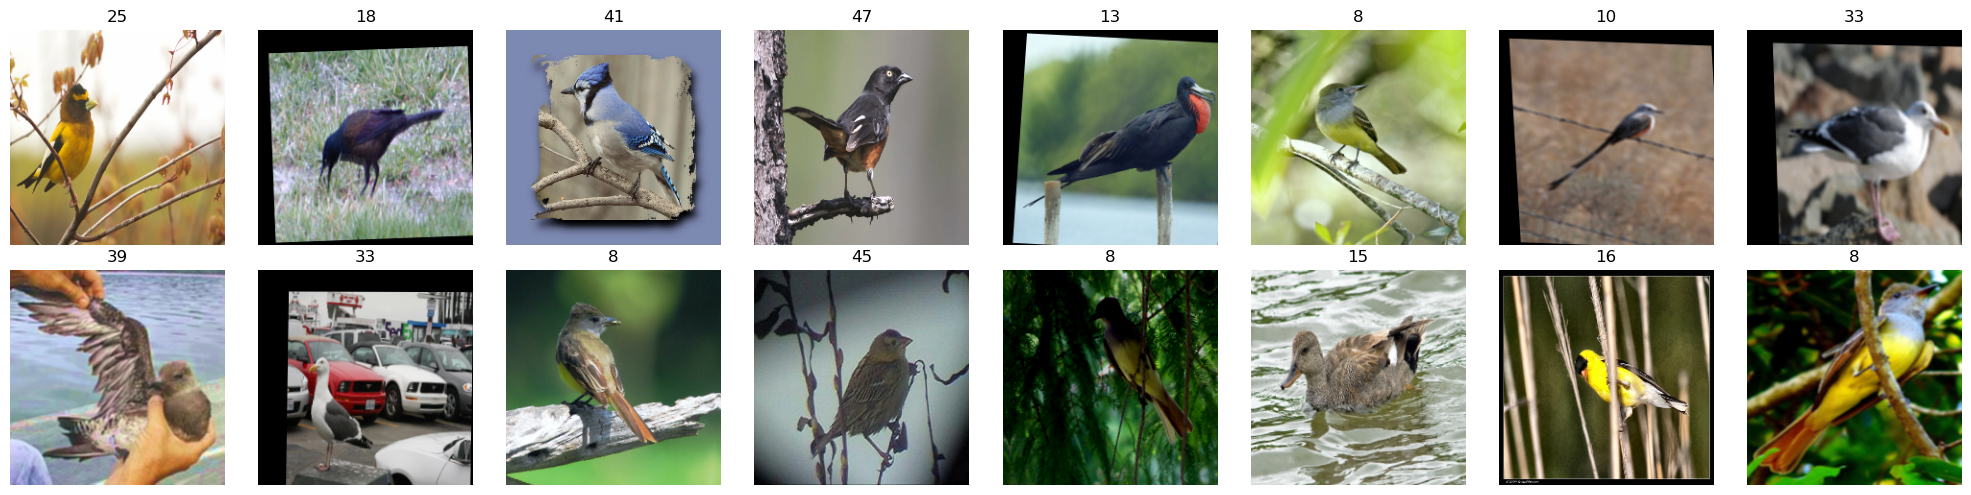

In [7]:
def display_batch(batch, cols=8):
    rows = ceil(len(batch[0]) / cols)
    fig_size = matplotlib.rcParams['figure.figsize'][0] / cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize = (fig_size * cols, fig_size * rows))
    for i, image in enumerate(batch[0]):
        image = image.permute(1, 2, 0)
        image = image * STD + MEAN
        predicted_label = int(batch[1][i])
        color = 'black'
        ax.ravel()[i].imshow((image * 255).type(torch.uint8))
        ax.ravel()[i].set_title(predicted_label, color=color)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

display_batch(next(iter(train_loader)))

In [8]:
def test_on_dataloader(model, loader, repeats=3):
    device = torch.device('cuda:0')
    model = model.to(device)
    correct = defaultdict()
    predicted = defaultdict(list)
    for repeat in range(repeats):
        for batch in loader:
            images, y, names = batch
            for name, label in zip(names, y):
                correct[name] = label

            images = images.to(device)
            pred = model.forward(images).detach().cpu()
            pred = F.softmax(pred, dim=1).argmax(dim=1)

            for name, p in zip(names, pred):
                predicted[name].append(p)

    predicted_most_common = {}
    for name, preds in predicted.items():
        most_common = max(set(preds), key=preds.count)
        predicted_most_common[name] = most_common

    n = 0
    for k in correct:
        true = correct[k]
        pred = predicted_most_common[k]
        n += true == pred
    n = float(n) / len(correct)

    acc_mean = n

    acc_single = []
    for i in range(repeats):
        n = 0
        for k in correct:
            true = correct[k]
            pred = predicted[k][i]
            n += true == pred
        n = float(n) / len(correct)

        acc_single.append(n)
    return acc_mean, acc_single

In [9]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()

        features = list(torchvision.models.resnet152(weights=torchvision.models.ResNet152_Weights.IMAGENET1K_V2).children())[:-2]
        # features = nn.Sequential(*features)

        self.features_1 = nn.Sequential(*features[:-1])
        self.features_2 = nn.Sequential(*features[-1:])
        
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Dropout(0.8),
            nn.Linear(2048 , 50)
        )

        self.loss = nn.CrossEntropyLoss(label_smoothing=0.1)
        self.acc = lambda pred, y: torch.sum(F.softmax(pred, dim=1).argmax(dim=1) == y) / y.shape[0]

    def forward(self, x):
        x = self.features_1(x)
        x = self.features_2(x)
        x = self.classifier(x)
        return x

In [10]:
def freeze_model(model):
        for param in model.parameters():
            param.requires_grad = True
        for param in model.features_1.parameters():
            param.requires_grad = False

def unfreeze_model(model):
    for param in model.parameters():
        param.requires_grad = True

In [14]:
def train(model, loss, accuracy, optimizer, scheduler, num_epochs):
    print('{:<7s}|{:^20s}|{:^20s}|'.format('', 'Train', 'Valid'))
    print('{:<7s}|{:>10s}{:>10s}|{:>10s}{:>10s}|'.format('Epoch', 'Loss', 'Acc', 'Loss', 'Acc'))
    print('-' * 50)
    
    for epoch in range(num_epochs):
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_loader
                model.train()
            else:
                dataloader = valid_loader
                model.eval() 

            running_loss = 0.
            running_acc = 0.
            
            for sample in dataloader:
                x = sample[0]
                y = sample[1]
                x = x.to(device)
                y = y.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(x)
                    print(preds.shape, y.shape)
                    loss_value = loss(preds, y)

                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                running_loss += loss_value.item()
                running_acc += accuracy(preds, y)

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)
                        
            # writer.add_scalar('Loss/train', epoch_loss, global_epoch)
            # writer.add_scalar('Accuracy/train', epoch_acc, global_epoch)
            # writer.flush()
            
            # if epoch_loss < best_loss:
            #     best_model_loss = copy.deepcopy(model)
            #     best_loss = epoch_loss
            # if epoch_acc > best_acc:
            #     best_model_acc = copy.deepcopy(model)
            #     best_acc = epoch_acc

            if phase == 'train':
                scheduler.step()
                print('{:>3d}/{:>3d}|{:>10.4f}{:>10.4f}|'.format(epoch + 1, num_epochs, epoch_loss, epoch_acc), end='')
            else:
                print('{:>10.4f}{:>10.4f}|'.format(epoch_loss, epoch_acc))

            # loss_history[phase].append(epoch_loss)
            # acc_history[phase].append(epoch_acc)
    model.eval()

In [1]:
model = Model().to(device)
freeze_model(model)
loss = nn.CrossEntropyLoss(label_smoothing=0.1)
accuracy = lambda x, y: (x.argmax(dim=1) == y.data).float().mean().data.cpu().numpy() 

optimizer = torch.optim.Adam([
    {'params': model.features_1.parameters(), 'lr': 3e-5},
    {'params': model.features_2.parameters(), 'lr': 3e-5},
    {'params': model.classifier.parameters()}
], lr=3e-4, weight_decay=5e-4)

scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer, 
    step_size=7,
    gamma=0.2,
    verbose=False
)
train(model, loss, accuracy, optimizer, scheduler, 30)

NameError: name 'Model' is not defined

In [ ]:
test_on_dataloader(model, valid_loader, 3)

(0.782, [0.738, 0.744, 0.744])

In [ ]:
best_model = Model()
best_model.load_state_dict(torch.load('runs/pl_classifier/epoch=25-val_acc=0.857.ckpt')['state_dict'])
best_model.eval()
test_on_dataloader(best_model, valid_loader, 3)

(0.854, [0.846, 0.844, 0.834])

In [ ]:
model = best_model

In [ ]:
for param in model.parameters():
    print(param.requires_grad)

In [ ]:
unfreeze_model(model)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-6, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer, 
    step_size=7,
    gamma=0.2,
    verbose=False
)
train(model, loss, accuracy, optimizer, scheduler, 15)

       |       Train        |       Valid        |
Epoch  |      Loss       Acc|      Loss       Acc|
--------------------------------------------------
  1/ 15|    1.1005    0.9805|    1.5520    0.8359|
  2/ 15|    1.0064    0.9885|    1.4391    0.8359|
  3/ 15|    0.9353    0.9830|    1.2925    0.8477|
  4/ 15|    0.9114    0.9825|    1.3078    0.8184|
  5/ 15|    0.8884    0.9850|    1.2497    0.8398|
  6/ 15|    0.8795    0.9865|    1.2586    0.8379|
  7/ 15|    0.8622    0.9905|    1.1971    0.8516|
  8/ 15|    0.8639    0.9905|    1.2012    0.8457|
  9/ 15|    0.8609    0.9915|    1.2320    0.8477|
 10/ 15|    0.8558    0.9915|    1.2463    0.8438|
 11/ 15|    0.8551    0.9925|    1.2379    0.8379|
 12/ 15|    0.8611    0.9920|    1.2065    0.8477|
 13/ 15|    0.8553    0.9870|    1.2792    0.8242|
 14/ 15|    0.8534    0.9950|    1.2402    0.8496|
 15/ 15|    0.8511    0.9910|    1.2287    0.8438|
